# CMIP6 Precip Analysis Example

In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20, interval='2s')
client = Client(cluster)
client

Client Scheduler: tcp://10.48.123.3:46609 Dashboard: /user/pangeo-data-pan--cmip6-examples-r9iylbwg/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,ts,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,ua,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,pr,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,ts,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...


In [4]:
df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
len(df_3hr_pr)

18

In [5]:
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,ts,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,ua,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,pr,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,ts,gn,gs://pangeo-cmip6/AR6_WG1/AerChemMIP/BCC/BCC-E...


In [6]:
run_counts = df_3hr_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id         experiment_id     
BCC-CSM2-MR       historical            1
                  ssp245                1
                  ssp585                1
CNRM-CM6-1        historical            1
                  ssp245                1
                  ssp585                1
CNRM-ESM2-1       historical            1
                  ssp245                1
                  ssp585                1
GISS-E2-1-G       historical            1
IPSL-CM6A-ATM-HR  highresSST-present    1
IPSL-CM6A-LR      highresSST-present    1
                  historical            1
                  ssp245                1
                  ssp585                1
MRI-ESM2-0        historical            1
NICAM16-7S        highresSST-present    1
NICAM16-8S        highresSST-present    1
Name: zstore, dtype: int64

In [7]:
source_ids = []
experiment_ids = ['historical', 'ssp585']
for name, group in df_3hr_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR']

In [8]:
source_id = source_ids[0]

def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    uri = df_3hr_pr[(df_3hr_pr.source_id == source_id) &
                         (df_3hr_pr.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [9]:
def precip_hist(ds, nbins=100, pr_log_min=-3, pr_log_max=2):
    """
    Calculate precipitation histogram for a single model. 
    Lazy.
    """
    assert ds.pr.units == 'kg m-2 s-1'
    
    # mm/day
    bins_mm_day = np.hstack([[0], np.logspace(pr_log_min, pr_log_max, nbins)]) 
    bins_kg_m2s = bins_mm_day / (24*60*60)

    pr_hist = histogram(ds.pr, bins=[bins_kg_m2s], dim=['lon']).mean(dim='time')
    
    log_bin_spacing = np.diff(np.log(bins_kg_m2s[1:3])).item()
    pr_hist_norm = 100 * pr_hist / ds.dims['lon'] / log_bin_spacing
    pr_hist_norm.attrs.update({'long_name': 'zonal mean rain frequency',
                               'units': '%/Δln(r)'})
    return pr_hist_norm

def precip_hist_for_expts(dsets, experiment_ids):
    """
    Calculate histogram for a suite of experiments.
    Eager.
    """
    # actual data loading and computations happen in this next line
    pr_hists = [precip_hist(ds).load()
            for ds in [ds_hist, ds_ssp]]
    pr_hist = xr.concat(pr_hists, dim=xr.Variable('experiment_id', experiment_ids))
    return pr_hist

In [10]:
results = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1980', '2000'))
    ds_ssp = load_pr_data(source_id, 'ssp585').sel(time=slice('2080', '2100'))
    pr_hist = precip_hist_for_expts([ds_hist, ds_ssp], experiment_ids)
    results[source_id] = pr_hist

In [11]:
def plot_precip_changes(pr_hist, vmax=5):
    """
    Visualize the output
    """
    pr_hist_diff = (pr_hist.sel(experiment_id='ssp585') - 
                    pr_hist.sel(experiment_id='historical'))
    pr_hist.sel(experiment_id='historical')[:, 1:].plot.contour(xscale='log', colors='0.5', levels=21)
    pr_hist_diff[:, 1:].plot.contourf(xscale='log', vmax=vmax, levels=21)

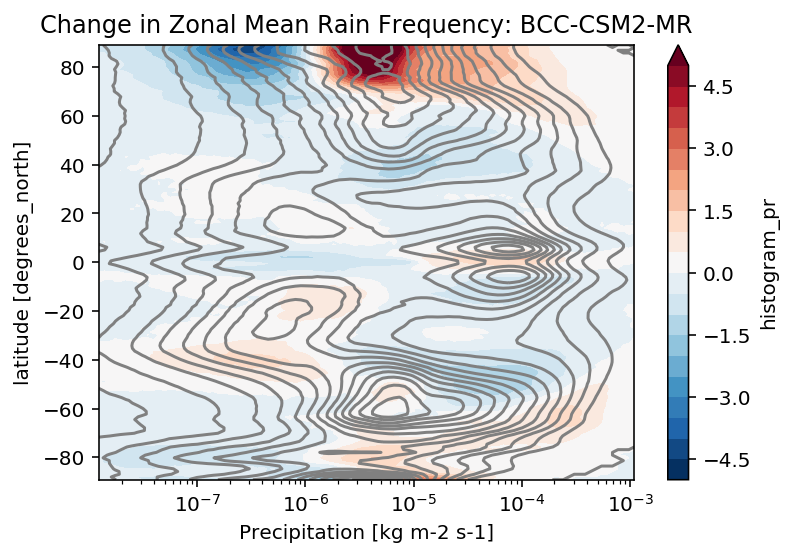

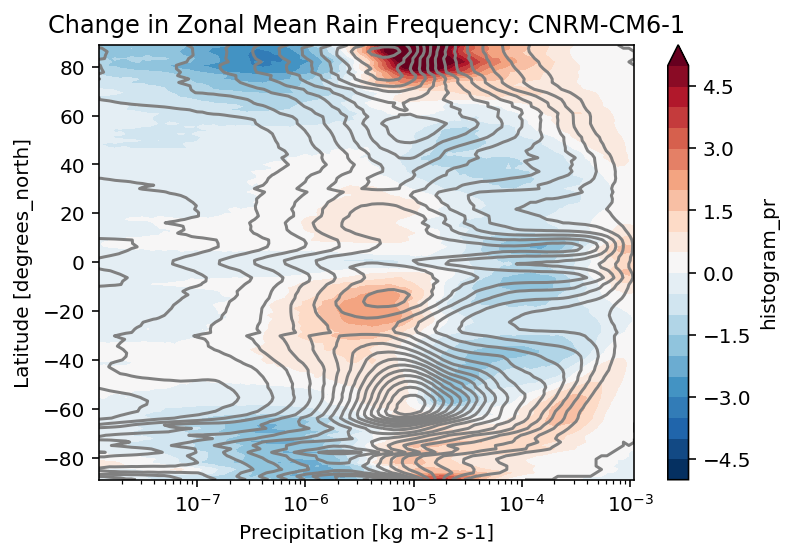

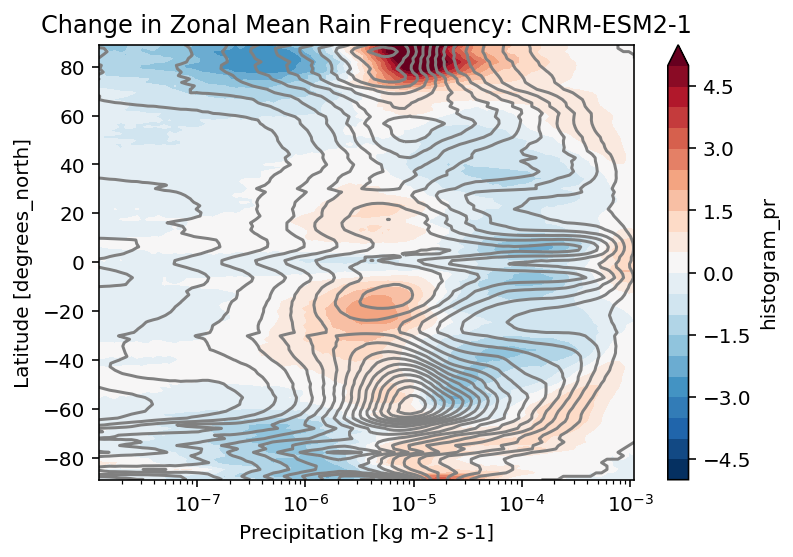

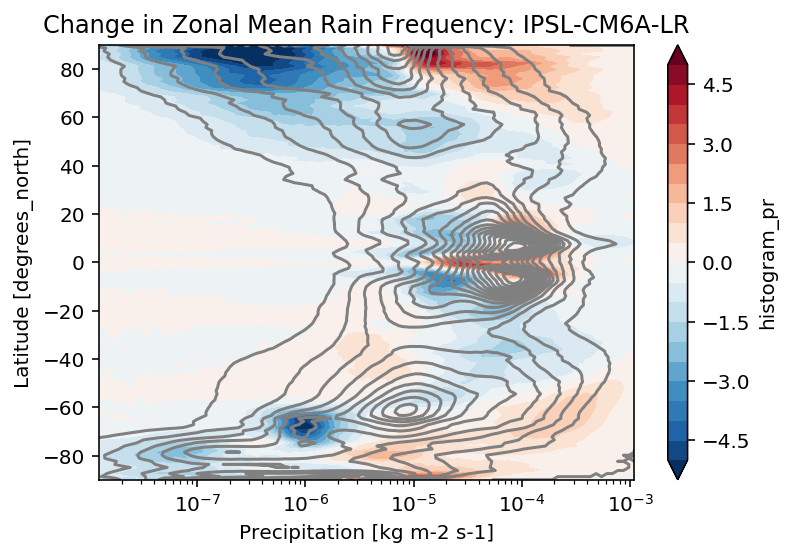

In [12]:
title = 'Change in Zonal Mean Rain Frequency'
for source_id, pr_hist in results.items():
    plt.figure()
    plot_precip_changes(pr_hist)
    plt.title(f'{title}: {source_id}')